# TM10007 Assignment template

In [67]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [68]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn as sns
import os

# Classifiers
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve

from sklearn.svm import SVR

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter 
from scipy.stats import shapiro
from scipy.signal import find_peaks
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc



def load_data():
    this_directory = os.getcwd()
    data = pd.read_csv(os.path.join(this_directory, 'Lipo_radiomicFeatures_with_nans.csv'), index_col=0)
    return data

data = load_data()

# Load the dataset
file_path = "data.csv"  # Ensure the dataset is in the same directory as the notebook
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Columns: 495 entries, ID to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(2)
memory usage: 444.9+ KB


,ID,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
0,Lipo-001_0,liposarcoma,0.368434,0.262371,26.200395,8.174390,20.940000,13.551937,0.694139,0.227848,...,0.049726,0.196019,0.927821,-0.407270,0.0,0,0.625304,3238.304991,0.315148,14.462361
1,Lipo-002_0,liposarcoma,0.660571,0.179013,55.155046,9.318741,9.546044,7.051937,0.871182,0.125279,...,0.036186,0.167471,1.137972,0.411968,0.0,0,0.563659,15364.724390,0.251255,17.170274
2,Lipo-003_0,lipoma,0.365191,0.157712,30.577026,8.963647,17.695139,10.772365,0.704710,0.137529,...,0.128167,0.220546,0.829650,-0.520344,0.0,0,0.705679,3771.798158,0.369366,14.394812
3,Lipo-004_0,liposarcoma,0.372210,0.169761,94.006805,33.512409,21.049148,15.928362,0.754497,0.186559,...,0.000000,0.107987,3.130011,10.399652,0.0,0,0.438399,4707.658397,0.000000,15.733482
4,Lipo-005_0,lipoma,0.369120,0.167485,94.612701,31.250821,17.059573,15.239905,0.774545,0.192922,...,0.000000,0.087662,3.284943,11.840826,0.0,0,0.356330,6171.440113,0.000000,16.682154


## Preprocessing
### Missing values & Clean-up

In [69]:
# Drop ID column as it is not useful for training
df.drop(columns=['ID'], inplace=True)

# Check for missing values and store them
missing_values = df[df.isna().any(axis=1)]

if not missing_values.empty:
    print(f"{missing_values.shape[0]} samples with missing values stored in missing_values")
    df = df.drop(missing_values.iloc[0:,:].index)
else:
    print("No missing values found")

# Encode the target variable
df['label'] = df['label'].map({'lipoma': 0, 'liposarcoma': 1})

# Display dataset after preprocessing
df.head()

No missing values found


,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
0,1,0.368434,0.262371,26.200395,8.174390,20.940000,13.551937,0.694139,0.227848,0.096312,...,0.049726,0.196019,0.927821,-0.407270,0.0,0,0.625304,3238.304991,0.315148,14.462361
1,1,0.660571,0.179013,55.155046,9.318741,9.546044,7.051937,0.871182,0.125279,0.030465,...,0.036186,0.167471,1.137972,0.411968,0.0,0,0.563659,15364.724390,0.251255,17.170274
2,0,0.365191,0.157712,30.577026,8.963647,17.695139,10.772365,0.704710,0.137529,0.088020,...,0.128167,0.220546,0.829650,-0.520344,0.0,0,0.705679,3771.798158,0.369366,14.394812
3,1,0.372210,0.169761,94.006805,33.512409,21.049148,15.928362,0.754497,0.186559,0.123775,...,0.000000,0.107987,3.130011,10.399652,0.0,0,0.438399,4707.658397,0.000000,15.733482
4,0,0.369120,0.167485,94.612701,31.250821,17.059573,15.239905,0.774545,0.192922,0.119364,...,0.000000,0.087662,3.284943,11.840826,0.0,0,0.356330,6171.440113,0.000000,16.682154


## Data Description

In [70]:
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Find ratio lipoma - liposarcoma
print(f"Sick-Healthy ratio: {df['label'].sum()}-{df.shape[0]-df['label'].sum()}") 

# Gaussian distributed featues in healthy data
df_label0 = df[df['label']==0]
not_normal_dist0 = 0
for column in df.columns[1:]:
    column_data = df_label0[column].values

    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist0 += 1

# Gaussian distributed featues in sick data
df_label1 = df[df['label']==1]
not_normal_dist1 = 0
for column in df.columns[1:]:
    column_data = df_label1[column].values

    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist1 += 1

# Gaussian distributed featues in all data
not_normal_dist = 0
for column in df.columns[1:]:
    column_data = df[column].values

    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist += 1

print(f"Ratio of Gaussian/NonGaussian feature distribution in all data: {not_normal_dist} - {df.shape[1]-not_normal_dist-1}")
print(f"Ratio of Gaussian/NonGaussian feature distribution in healthy data: {not_normal_dist0} - {df_label0.shape[1]-not_normal_dist0}")
print(f"Ratio of Gaussian/NonGaussian feature distribution in sick data: {not_normal_dist1} - {df_label1.shape[1]-not_normal_dist1}")

The number of samples: 115
The number of columns: 494
Sick-Healthy ratio: 58-57


/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Ratio of Gaussian/NonGaussian feature distribution in all data: 66 - 427
Ratio of Gaussian/NonGaussian feature distribution in healthy data: 117 - 377
Ratio of Gaussian/NonGaussian feature distribution in sick data: 86 - 408


### Data Split

In [71]:
# Split into train and test
X = df
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, stratify=y, random_state = 49)
X_train.drop(columns=['label'], inplace=True)
X_test.drop(columns=['label'], inplace=True)
print(f'The number of features left: {(X_train.shape[1])}')
print(f'The number of samples in train data: {(X_train.shape[0])}')
print(f'The number of samples in test data: {(X_test.shape[0])}')


The number of features left: 493
The number of samples in train data: 92
The number of samples in test data: 23


### Data distribution & Scaling

In [72]:
# Check Datadistributions & Scaling
normal = 0
outliers = 0
scaler_count = {"standard": 0, "minmax": 0, "robust":0}
scalers = {}

for column in X_train.columns:
    column_data = X_train[column].values

    # Check for normal distribtuin
    statistic, pvalue = shapiro(column_data)
    not_normal_dist = 1 if float(pvalue) <= 0.05 else 0
    if float(pvalue) > 0.05:
        normal += 1
    
    # Check for outliers
    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = np.sum((column_data < lower_bound) | (column_data > upper_bound))
    if outliers_count > 0:
        outliers += 1
    
    # Choose appropriate scaler for each feature
    if not_normal_dist == 0:
        scalers[column] = StandardScaler()  
        scaler_count["standard"] += 1
    elif not_normal_dist != 0 and outliers_count == 0:
        scalers[column] = MinMaxScaler()  
        scaler_count["minmax"] += 1
    else:
        scalers[column] = RobustScaler()  
        scaler_count["robust"] += 1

scaled_data = pd.DataFrame()
for column in X_train.columns:
    column_data = X_train[column].values.reshape(-1,1)
    scalers[column].fit(column_data)
    scaled_column = scalers[column].transform(column_data)
    scaled_data[column] = scaled_column.flatten()
    
X_train = scaled_data
print(f"Standard scaler:{scaler_count["standard"]} -- MinMax scaler:{scaler_count["minmax"]} -- Robust scaler:{scaler_count["robust"]}")
print(f"Ratio of Gaussian/NonGaussian distributions in all data: {normal} - {X_train.shape[1]-normal}")
print(f"Ratio of NoOutliers/Outliers in features in all data: {X_train.shape[1]-outliers} - {outliers}")
print(scalers)

# Data scaling for test set without fitting again
scaled_test_data = pd.DataFrame()
for column in X_test.columns:
    column_data = X_test[column].values.reshape(-1,1)
    scaled_column = scalers[column].transform(column_data)
    scaled_test_data[column] = scaled_column.flatten()
X_test = scaled_test_data

# # Data scaling for missing_values set without fitting again moet pas later ofzo
# missing_values_data = pd.DataFrame()
# if missing_values.empty:
#     for column in missing_values.columns:
#         column_data = missing_values[column].values.reshape(-1,1)
#         scaled_column = scalers[column].transform(column_data)
#         missing_values_data[column] = scaled_column.flatten
# missing_values = missing_values


/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/vx/4c5kyxsd3z96qzr3650wtz7h0000gn/T/ipykernel_15020/1879055845.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scaled_data[column] = scaled_column.flatten()
/var/folders/vx/4c5kyxsd3z96qzr3650wtz7h0000gn/T/ipykernel_15020/1879055845.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

Standard scaler:88 -- MinMax scaler:29 -- Robust scaler:376
Ratio of Gaussian/NonGaussian distributions in all data: 88 - 405
Ratio of NoOutliers/Outliers in features in all data: 86 - 407
{'PREDICT_original_sf_compactness_avg_2.5D': StandardScaler(), 'PREDICT_original_sf_compactness_std_2.5D': MinMaxScaler(), 'PREDICT_original_sf_rad_dist_avg_2.5D': RobustScaler(), 'PREDICT_original_sf_rad_dist_std_2.5D': RobustScaler(), 'PREDICT_original_sf_roughness_avg_2.5D': RobustScaler(), 'PREDICT_original_sf_roughness_std_2.5D': RobustScaler(), 'PREDICT_original_sf_convexity_avg_2.5D': RobustScaler(), 'PREDICT_original_sf_convexity_std_2.5D': MinMaxScaler(), 'PREDICT_original_sf_cvar_avg_2.5D': RobustScaler(), 'PREDICT_original_sf_cvar_std_2.5D': RobustScaler(), 'PREDICT_original_sf_prax_avg_2.5D': StandardScaler(), 'PREDICT_original_sf_prax_std_2.5D': MinMaxScaler(), 'PREDICT_original_sf_evar_avg_2.5D': MinMaxScaler(), 'PREDICT_original_sf_evar_std_2.5D': RobustScaler(), 'PREDICT_original_sf_s

/var/folders/vx/4c5kyxsd3z96qzr3650wtz7h0000gn/T/ipykernel_15020/1879055845.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scaled_test_data[column] = scaled_column.flatten()
/var/folders/vx/4c5kyxsd3z96qzr3650wtz7h0000gn/T/ipykernel_15020/1879055845.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scaled_test_data[column] = scaled_column.flatten()
/var/folders/vx/4c5kyxsd3z96qzr3650wtz7h0000gn/T/ipykernel_15020/1879055845.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

### Feature Selection
#### Variance

In [73]:
# Feature selection based on variance
variance_selector = VarianceThreshold(threshold=0.01)
data_var= variance_selector.fit_transform(X_train.iloc[:, 1:])

print(f"Features reduced from {X_train.shape[1]} to {data_var.shape[1]} features after variation filtering")

Features reduced from 493 to 464 features after variation filtering


In [74]:
# Apply PCA based on them to explain 99% of the data
pca = decomposition.PCA(n_components= 0.99)
data_pca = pca.fit_transform(data_var)

print(f'The number of columns after variance selection: {(data_pca.shape[1])}')
print(f'The number of rows after variance selection: {(data_pca.shape[0])}')

The number of columns after variance selection: 1
The number of rows after variance selection: 92


#### Correlation 


In [75]:
# Removing redundant features based on correlation
data_var_df = pd.DataFrame(data_var)
corr_matrix = data_var_df.corr().abs()  # Get absolute correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation higher than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
data_cor = data_var_df.drop(columns=to_drop)

print(f"Features reduced from {data_var.shape[1]} to {data_cor.shape[1]} features after correlation filtering")


Features reduced from 464 to 278 features after correlation filtering


#### RFE: linear

/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

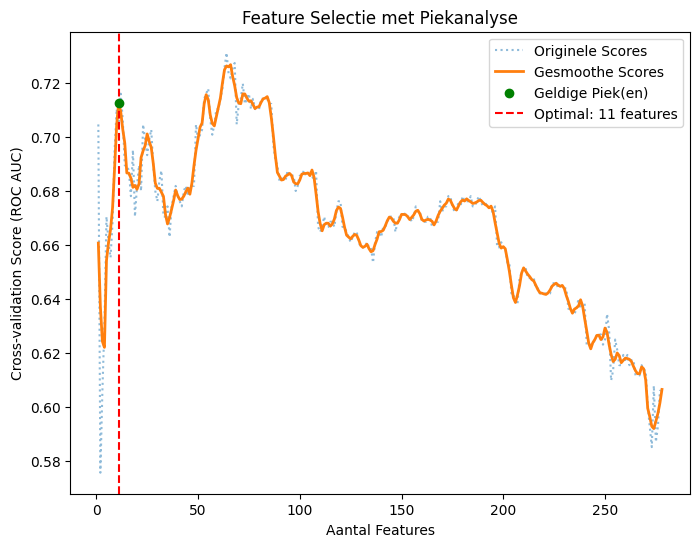

Optimale aantal features voor lineaire classifier: 11


In [76]:
# Linear feature selection by RFE
est_lin = LogisticRegression(max_iter=500)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est_lin, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_cor, y_train)

# Haal de CV-scores op
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth de scores met Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)  # Pas window_length aan als nodig

# Zoek pieken in de gesmoothe curve
peaks, properties = find_peaks(smoothed_scores, height=None)  # Zoekt alle pieken

# Voorwaarden
max_score = np.max(smoothed_scores)
threshold = max_score * 0.95  # 95% van de maximale score
feat_min = 5
feat_max = 20

# Filter pieken die:
# 1. Minimaal 5 features hebben (feat_min)
# 2. Maximaal 20 features hebben (feat_max)
# 3. Binnen de 5% marge van de max-score zitten (threshold)
valid_peaks = [p for p in peaks if feat_max >= num_features[p] >= feat_min and smoothed_scores[p] >= threshold]

# Selecteer de eerste geschikte piek, anders pakt hij de hoogste waarde
if valid_peaks:
    first_peak = valid_peaks[0]
    optimal_index = first_peak

    for next_peak in valid_peaks[1:]:
        if first_peak < next_peak <= first_peak + 3:
            if smoothed_scores[next_peak] > smoothed_scores[optimal_index]:
                optimal_index = next_peak
else:
    valid_indices = np.where((num_features >= 5) & (num_features <= 25))[0]
    optimal_index = valid_indices[np.argmax(smoothed_scores[valid_indices])]
optimal_features_lin = num_features[optimal_index]

# Plot de originele en gesmoothe scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Originele Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Gesmoothe Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Geldige Piek(en)", zorder=3)
plt.axvline(optimal_features_lin, color='r', linestyle="--", label=f"Optimal: {optimal_features_lin} features")
plt.xlabel("Aantal Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selectie met Piekanalyse")
plt.show()

print(f"Optimale aantal features voor lineaire classifier: {optimal_features_lin}")


#### RFE: non-linear


/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/ut

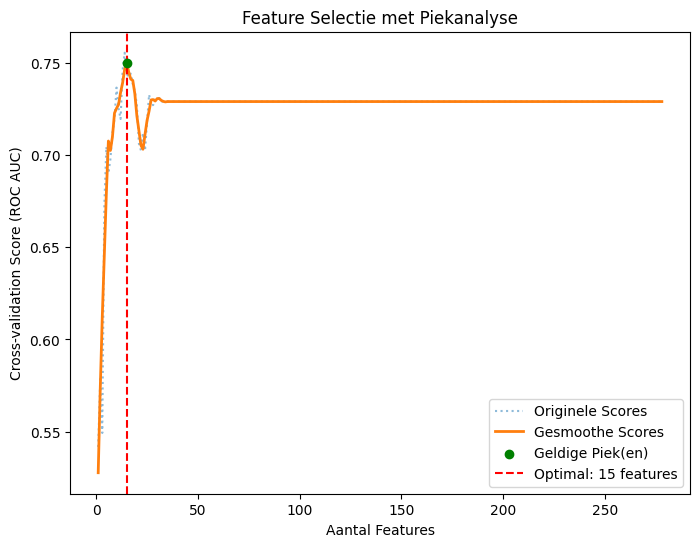

Optimale aantal features voor non-lineare classifier: 15


In [77]:
# Feature selection by RFE
est_nl = LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=42, verbose=-1)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est_nl, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_cor, y_train)

# Haal de CV-scores op
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth de scores met Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)  # Pas window_length aan als nodig

# Zoek pieken in de gesmoothe curve
peaks, properties = find_peaks(smoothed_scores, height=None)  # Zoekt alle pieken

# Voorwaarden
max_score = np.max(smoothed_scores)
threshold = max_score * 0.95  # 95% van de maximale score

# Filter pieken die:
# 1. Minimaal 5 features hebben (feat_min)
# 2. Maximaal 25 features hebben (feat_max)
# 3. Binnen de 5% marge van de max-score zitten (threshold)
valid_peaks = [p for p in peaks if feat_max >= num_features[p] >= feat_min and smoothed_scores[p] >= threshold]

# Selecteer de eerste geschikte piek, anders pakt hij de hoogste waarde
if valid_peaks:
    first_peak = valid_peaks[0]
    optimal_index = first_peak

    for next_peak in valid_peaks[1:]:
        if first_peak < next_peak <= first_peak + 3:
            if smoothed_scores[next_peak] > smoothed_scores[optimal_index]:
                optimal_index = next_peak
else:
    valid_indices = np.where((num_features >= 5) & (num_features <= 25))[0]
    optimal_index = valid_indices[np.argmax(smoothed_scores[valid_indices])]
optimal_features_nl = num_features[optimal_index]

# Plot de originele en gesmoothe scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Originele Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Gesmoothe Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Geldige Piek(en)", zorder=3)
plt.axvline(optimal_features_nl, color='r', linestyle="--", label=f"Optimal: {optimal_features_nl} features")
plt.xlabel("Aantal Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selectie met Piekanalyse")
plt.show()

print(f"Optimale aantal features voor non-lineare classifier: {optimal_features_nl}")

#### Final feature selections
As the non-linear ROC AUC does not make much sense, we choose to go forward with only the linear features.

In [78]:
# Linear feature selection with Logistic Regression
#logreg = LogisticRegression(random_state=42, max_iter=1000)
#logreg.fit(X_train, y_train)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)

#feature_importance = np.abs(logreg.coef_[0])
feature_importance = rf.feature_importances_

n_importance = optimal_features_lin
important_features_lin = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:n_importance]
features = X_train.columns[important_features_lin]

print(f"Most important features (indices), linear: {features}")
print(f"Feature importances (coefficients): {feature_importance[important_features_lin]}")

# Filtering in datasets
X_train = X_train[features]
X_test = X_test[features]
print(features)

Most important features (indices), linear: Index(['PREDICT_original_sf_volume_2.5D',
       'PREDICT_original_tf_Gabor_mean_F0.2_A0.79',
       'PREDICT_original_sf_area_avg_2.5D',
       'PREDICT_original_sf_area_std_2.5D',
       'PREDICT_original_vf_Frangi_full_mean_SR(1.0, 10.0)_SS2.0',
       'PREDICT_original_vf_Frangi_full_entropy_SR(1.0, 10.0)_SS2.0',
       'PREDICT_original_tf_LBP_std_R15_P36',
       'PREDICT_original_tf_Gabor_min_F0.05_A1.57',
       'PREDICT_original_tf_Gabor_mean_F0.05_A0.79',
       'PREDICT_original_tf_Gabor_mean_F0.5_A0.79',
       'PREDICT_original_logf_quartile_range_sigma1'],
      dtype='object')
Feature importances (coefficients): [0.02563189 0.01670482 0.01550936 0.01216532 0.01134928 0.01040938
 0.00946002 0.00935732 0.00889537 0.00889325 0.00869667]
Index(['PREDICT_original_sf_volume_2.5D',
       'PREDICT_original_tf_Gabor_mean_F0.2_A0.79',
       'PREDICT_original_sf_area_avg_2.5D',
       'PREDICT_original_sf_area_std_2.5D',
       'PREDICT_

#### Return samples with missing values if possible

In [79]:
# Check for missing values in test data
missing_values.dropna(subset=features, inplace=True)

# Now we only keep the important features 
y_missing = missing_values['label'].map({'lipoma': 0, 'liposarcoma': 1})
missing_values.drop(columns=['label'], inplace=True)
X_missing = missing_values[features]

# And add it to the rest of the test data
X_test = pd.concat([X_test, X_missing], axis=0)
y_test = pd.concat([y_test, y_missing], axis=0)


/var/folders/vx/4c5kyxsd3z96qzr3650wtz7h0000gn/T/ipykernel_15020/193519558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_values.dropna(subset=features, inplace=True)
/var/folders/vx/4c5kyxsd3z96qzr3650wtz7h0000gn/T/ipykernel_15020/193519558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_values.drop(columns=['label'], inplace=True)


#### Classifiers

/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance m

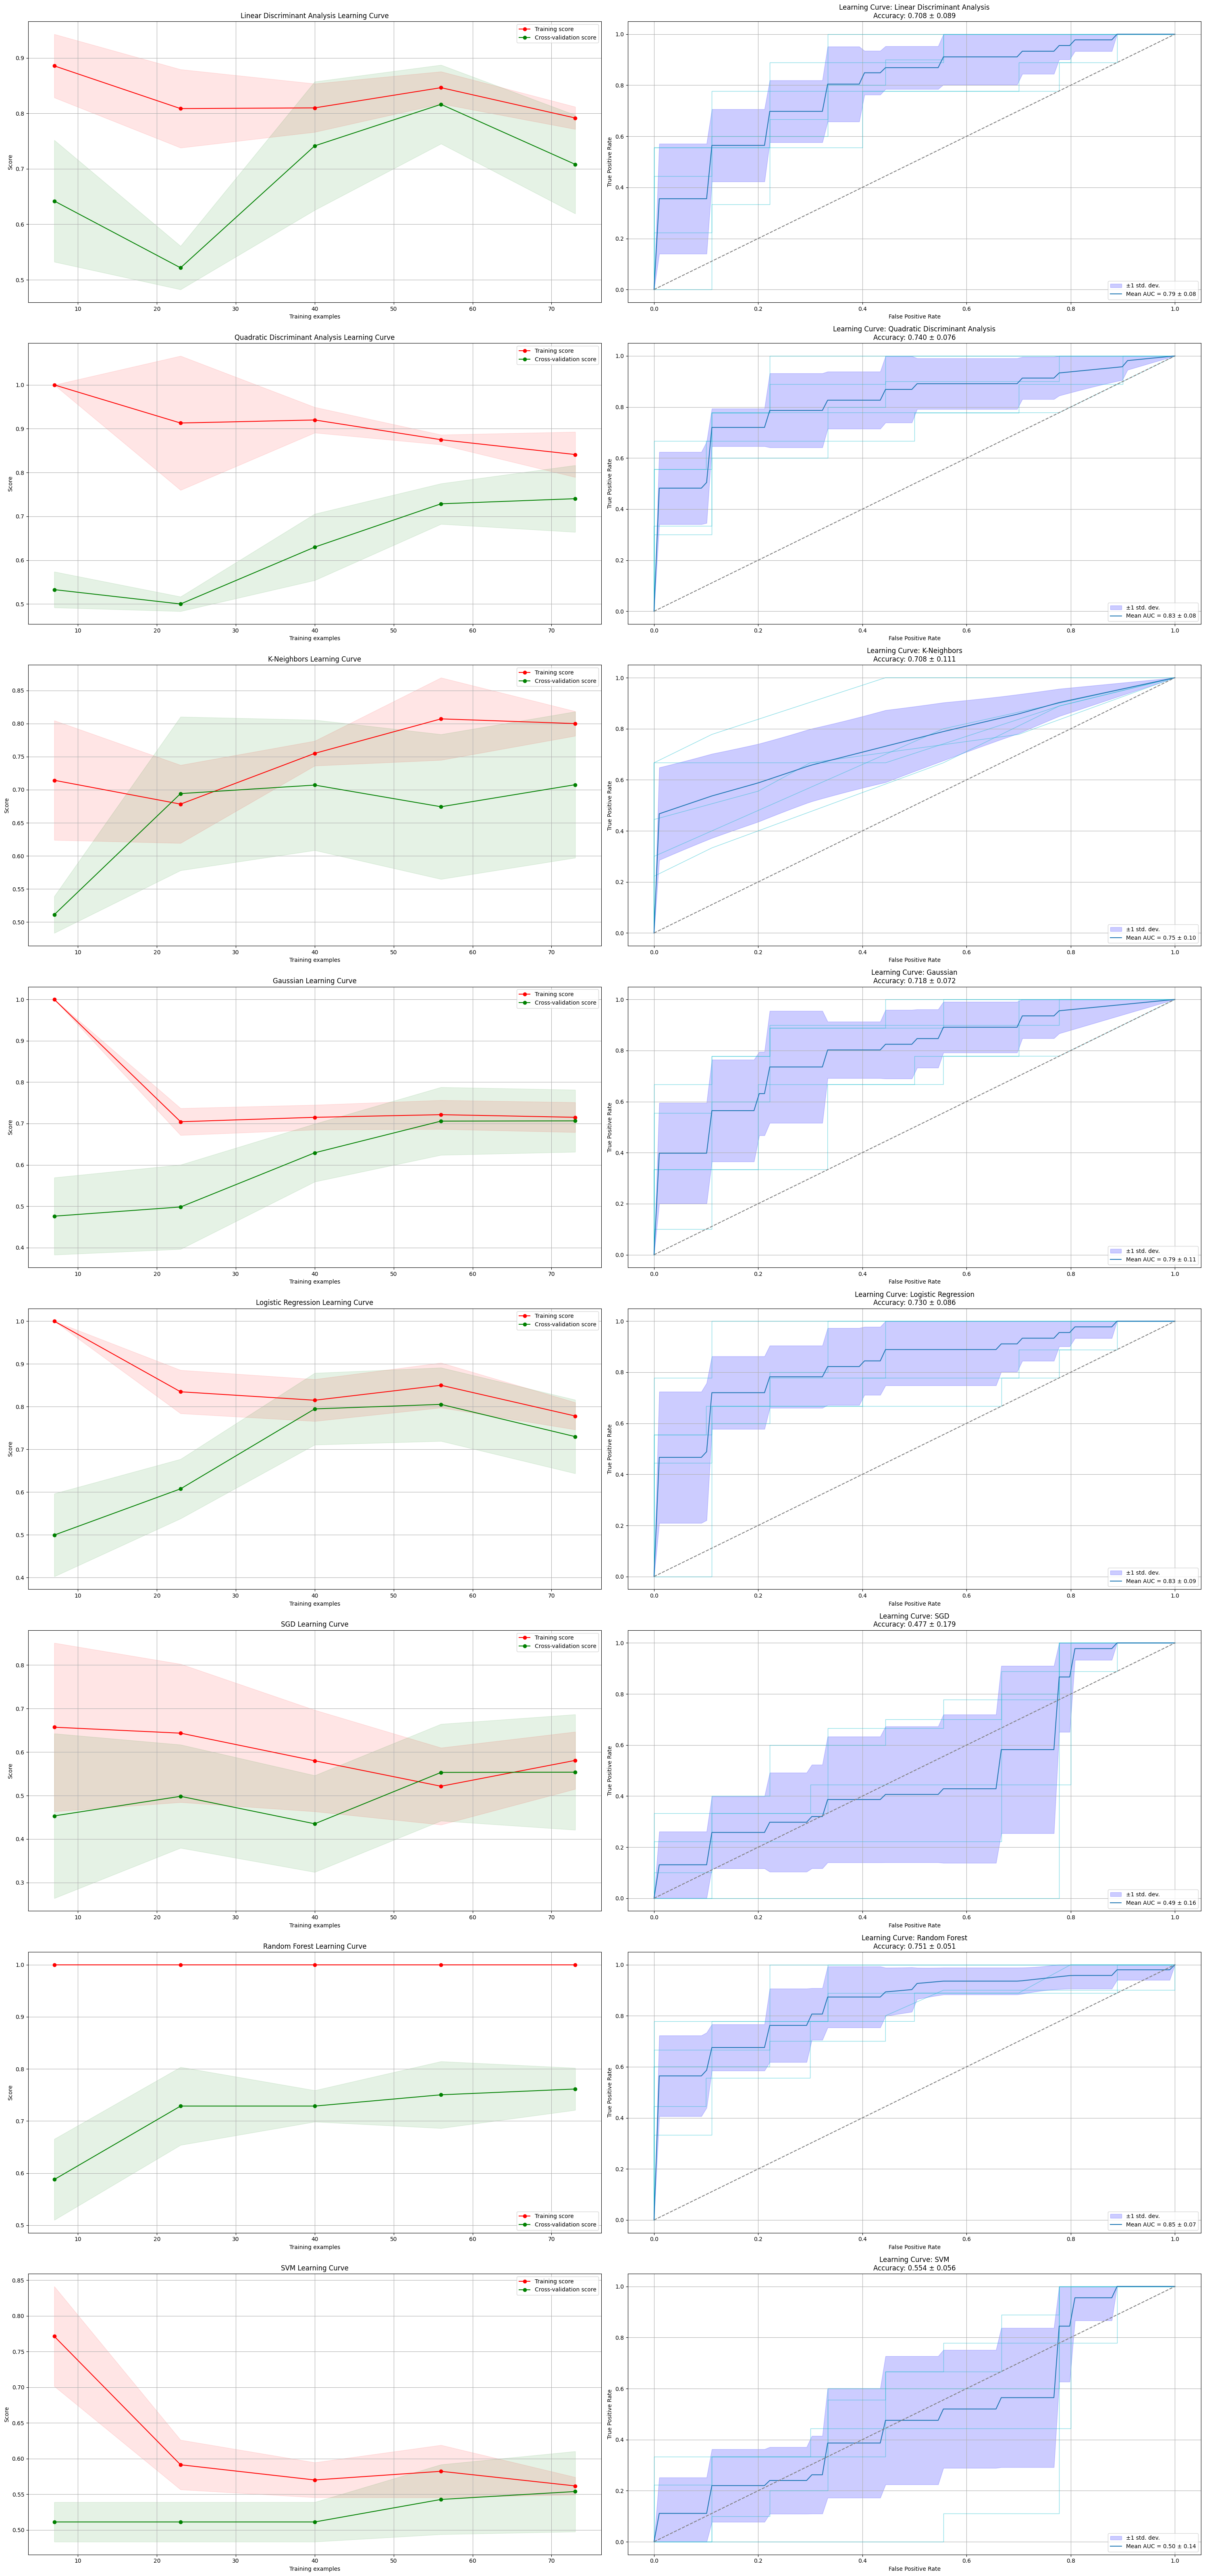

In [80]:
# Combination of classifiers
# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

# Custom function to plot learning curve
def plot_learning_curve(estimator, title, Xs, Ys, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate learning curves, fill shaded area for train/test scores
    """
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, Xs, Ys, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, random_state=42)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),KNeighborsClassifier(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),RandomForestClassifier(),svm.SVC()]
clf_names = ["Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "K-Neighbors", "Gaussian", 
               "Logistic Regression", "SGD", "Random Forest", "SVM"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_scores = {}

# Create a plot grid
fig, axes = plt.subplots(len(clsfs), 2, figsize=(30, 8*len(clsfs)))
axes = axes.flatten()  # Make it a 1D array so you can index it easily
num = 0

# Loop through classifiers
for clf, name in zip(clsfs, clf_names):
    # --- 1. Learning Curve ---
    title = f"{name} Learning Curve"
    plot_learning_curve(clf, title, X_train, y_train, axes[num*2], cv = cv)
    num += 1
    
    # --- 2. ROC AUC via Cross-Validation ---
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    accs = []

    for train_idx, test_idx in cv.split(X_train, y_train):
        clf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        if hasattr(clf, "predict_proba"):
            probas = clf.predict_proba(X_train.iloc[test_idx])[:, 1]
        elif hasattr(clf, "decision_function"):
            probas = clf.decision_function(X_train.iloc[test_idx])
        else:
            continue  

        fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], probas)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

        # Calculate accuracy for this fold and store
        y_pred = clf.predict(X_train.iloc[test_idx])
        accs.append(np.mean(y_pred == y_train.iloc[test_idx]))  # Store accuracy for this fold

        # Light grey ROC line for each fold
        axes[num * 2 -1].plot(fpr, tpr, color='#17becf', lw=1, alpha=0.5)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    cv_auc_scores[name] = mean_auc
    mean_acc = np.mean(accs)  # Mean accuracy
    std_acc = np.std(accs)    # Standard deviation of accuracy
    cv_auc_scores[name] = mean_auc

    axes[num * 2 -1].fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0),
                np.minimum(mean_tpr + std_tpr, 1), alpha=0.2, color='blue', label='±1 std. dev.')
    axes[num * 2 -1].plot(mean_fpr, mean_tpr, label=f"Mean AUC = {mean_auc:.2f} ± {std_auc:.2f}")
    axes[num * 2 -1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[num * 2 -1].set_title(f"ROC Curve CV: {name}")
    axes[num * 2 -1].set_xlabel("False Positive Rate")
    axes[num * 2 -1].set_ylabel("True Positive Rate")
    axes[num * 2 -1].legend(loc="lower right")
    axes[num * 2 -1].grid()

    axes[num * 2 -1].set_title(f"Learning Curve: {name}\nAccuracy: {mean_acc:.3f} ± {std_acc:.3f}")


plt.tight_layout()
plt.show()

#### Hyperparameters

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#gaussian
param_grid_gnb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

grid_gnb = GridSearchCV(GaussianNB(), param_grid_gnb, cv=5, scoring='accuracy')
grid_gnb.fit(X_train, y_train)

print("Best parameters (GaussianNB):", grid_gnb.best_params_)
print("Best CV accuracy:", grid_gnb.best_score_)

#random forest 
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 8, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print("Best parameters (Random Forest):", grid_rf.best_params_)
print("Best CV accuracy:", grid_rf.best_score_)

# logistic regression
param_grid_lr = {
    'C': [1, 10],
    'penalty': ['l1', 'l2'],  # 'l1' requires solver='liblinear'
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("Best parameters (Logistic Regression):", grid_lr.best_params_)
print("Best CV accuracy:", grid_lr.best_score_)

# # svm 
# param_grid_svc = {
#     'C': [0.1, 1],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': ['scale', 'auto']
# }

# grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy', n_jobs = -1, verbose = 1)
# grid_svc.fit(X_train, y_train)

# print("Best parameters (SVM):", grid_svc.best_params_)
# print("Best CV accuracy:", grid_svc.best_score_)
#grid_svc.best_params_ = {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


Best parameters (GaussianNB): {'var_smoothing': 1e-09}
Best CV accuracy: 0.7508771929824561
Best parameters (Random Forest): {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best CV accuracy: 0.7409356725146198
Best parameters (Logistic Regression): {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV accuracy: 0.7520467836257311


/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users


GaussianNB Evaluation:
Accuracy: 0.6956521739130435
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.69      0.75      0.72        12

    accuracy                           0.70        23
   macro avg       0.70      0.69      0.69        23
weighted avg       0.70      0.70      0.69        23

Confusion Matrix:
 [[7 4]
 [3 9]]

Random Forest Evaluation:
Accuracy: 0.8260869565217391
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.79      0.92      0.85        12

    accuracy                           0.83        23
   macro avg       0.84      0.82      0.82        23
weighted avg       0.84      0.83      0.82        23

Confusion Matrix:
 [[ 8  3]
 [ 1 11]]

Logistic Regression Evaluation:
Accuracy: 0.8695652173913043
Classification Report:
               precision    reca

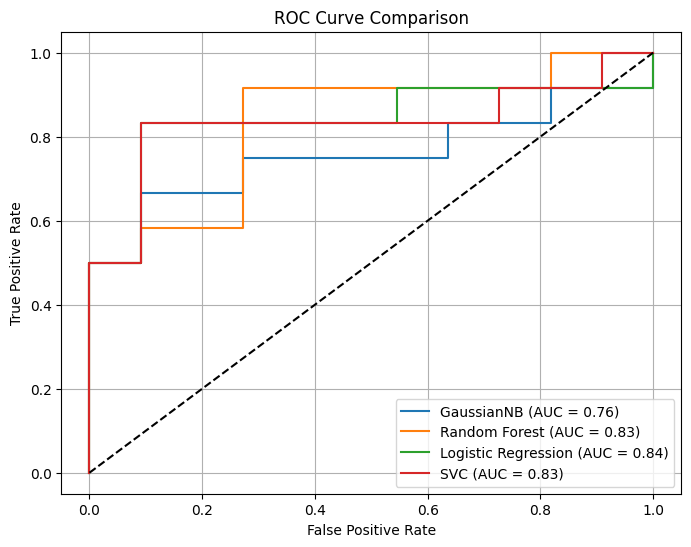

In [82]:
# Retraining models with the best parameters from GridSearch
best_gnb = GaussianNB(**grid_gnb.best_params_)
best_rf = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
best_lr = LogisticRegression(**grid_lr.best_params_, max_iter=1000)
#best_svc = SVC(**grid_svc.best_params_)
best_svc = SVC(C=1, gamma='scale', kernel='linear') 

# Fit all best models on the full training data
best_gnb.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_lr.fit(X_train, y_train)
best_svc.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
    "GaussianNB": best_gnb,
    "Random Forest": best_rf,
    "Logistic Regression": best_lr,
    "SVC": best_svc
}

for name, model in models.items():
    if name == "Random Forest":
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)

    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_curve, auc

# ROC curve 
plt.figure(figsize=(8, 6))

for name, model in models.items():
    if name == "Random Forest":
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue  # skip if scoring not available

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Diagonal line (random guess)
plt.plot([0, 1], [0, 1], 'k--')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [83]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

for name, model in models.items():
    print(f"\n{name}:")
    evaluate_accuracy(model, X_test, y_test)



GaussianNB:
Accuracy: 69.57%

Random Forest:
Accuracy: 82.61%

Logistic Regression:
Accuracy: 86.96%

SVC:
Accuracy: 82.61%


In [84]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from scipy.stats import mode

def evaluate_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_pred

model_preds = {}
misclassified_indices = {}

for name, model in models.items():
    print(f"\n{name}:")
    y_pred = evaluate_accuracy(model, X_test, y_test)
    
    # Store predictions and misclassifications
    model_preds[name] = y_pred
    misclassified_indices[name] = np.where(y_pred != y_test)[0]

# Create comparison matrix
n = len(models)
comparison_matrix = np.zeros((n, n), dtype=int)

# Fill the matrix
for i, name_i in enumerate(list(models.keys())):
    mis_i = misclassified_indices[name_i]
    comparison_matrix[i, i] = len(mis_i)  # Diagonal = total misclassifications

    for j, name_j in enumerate(list(models.keys())):
        if i == j:
            continue
        # Of the samples model_i misclassified, how many did model_j get right?
        y_pred_j = model_preds[name_j]
        comparison_matrix[i, j] = np.sum(y_pred_j[mis_i] == y_test.iloc[mis_i])

# Display as DataFrame
comp_df = pd.DataFrame(comparison_matrix, index=list(models.keys()), columns=list(models.keys()))
print("\nMisclassification Correction Matrix:")
print(comp_df)

# ----- 🗳️ Majority Voting between RF, LR, SVC -----
voting_models = ['Random Forest', 'Logistic Regression', 'SVC']
voting_preds = np.array([model_preds[name] for name in voting_models])

# Apply majority vote across models (axis=0 means vote for each sample)
voted_pred, _ = mode(voting_preds, axis=0, keepdims=False)

# Evaluate accuracy
voting_accuracy = accuracy_score(y_test, voted_pred)
print(f"\nVoting Accuracy (RF + LR + SVC): {voting_accuracy * 100:.2f}%")


GaussianNB:
Accuracy: 69.57%

Random Forest:
Accuracy: 82.61%

Logistic Regression:
Accuracy: 86.96%

SVC:
Accuracy: 82.61%

Misclassification Correction Matrix:
                     GaussianNB  Random Forest  Logistic Regression  SVC
GaussianNB                    7              5                    5    5
Random Forest                 2              4                    2    2
Logistic Regression           1              1                    3    0
SVC                           2              2                    1    4

Voting Accuracy (RF + LR + SVC): 86.96%
